In [1]:
using DrWatson

In [2]:
@quickactivate
projectname()

"NowcastingHuascaran"

In [3]:
using PyCall
using Serialization
using ClimateBase
using Plots
using HDF5

In [4]:
archs = readdir("../artifacts/experiments/"; join=true)

6-element Vector{String}:
 "../artifacts/experiments/1"
 "../artifacts/experiments/Input6" ⋯ 21 bytes ⋯ "2_3x3x48_Drop0.2_1x1x48_3x3x3x1"
 "../artifacts/experiments/Input6" ⋯ 36 bytes ⋯ "2_3x3x64_Drop0.2_1x1x64_3x3x3x1"
 "../artifacts/experiments/Input6" ⋯ 57 bytes ⋯ "_ConvLSTM2D1x1x64_Conv3D3x3x3x1"
 "../artifacts/experiments/Input64x64x8_5x5x64_3x3x64_1x1x16"
 "../artifacts/experiments/failed"

In [5]:
const tf = pyimport("tensorflow")
const keras = pyimport("tensorflow.keras")


PyObject <module 'tensorflow.keras' from 'C:\\Users\\coolh\\miniconda3\\lib\\site-packages\\keras\\api\\_v2\\keras\\__init__.py'>

In [6]:
ds_path = datadir("exp_pro", "GLM-L2-LCFA_8km_5m_boxes", "2019", "jls")
ds = deserialize(readdir(ds_path; join=true)[1])

19-element Vector{<:ClimArray}:
 ClimArray (named flash_extent_density) with 64×64×288 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×32 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×25 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×47 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×135 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×132 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×103 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×76 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×117 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×97 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×30 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×27 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×110 Lon×Lat×Time data
 ClimArray (named flash_ex

In [7]:
function binarize!(x)
    z = zero(eltype(x))
    for i in 1:length(x)
        x[i] = x[i] > z
    end
    x
end

binarize! (generic function with 1 method)

In [8]:
function animation(ds)
    anim = @time @animate for i = 1:size(ds, 3)
        heatmap(ds[:,:,i], c=cgrad([:black, :white]), legend=false, size=(480,480), clim=(0,15))
    end
    gif(anim, fps=4)
end

animation (generic function with 1 method)

In [9]:
function animation_comparation(ds, ds2, fps)
    anim = @time @animate for i = 1:size(ds, 3)
        h1 = heatmap(ds[:,:,i], c=cgrad([:black, :white]), legend=false, clim=(0, 1))
        h2 = heatmap(ds2[:,:,i], c=cgrad([:black, :white]), legend=false, clim=(0,1))
        plot(h1, h2, size=(480*2,480), title="Frame $i")
    end
    gif(anim, fps=fps)
end

animation_comparation (generic function with 1 method)

In [10]:
function animation_comparation_colors(pred, ds2, fps, cut=32)
    anim = @time @animate for i = 1:size(pred, 3)
        h1 = heatmap(pred[:,:,i], c=cgrad([:black, :white]), legend=false, clim=(0,1))
        heatmap!(ds2[:,:,i], c=cgrad([:black, :yellow]), legend=false, clim=(0,1))
        plot(h1, size=(480,480), title="Frame $i")
    end
    gif(anim, fps=fps)
end

animation_comparation_colors (generic function with 2 methods)

In [11]:
function rolling_predictions(model, dataset, n = 8, steps = 1)
    predicted = copy(dataset)
    for idx = 1:steps:size(dataset, 3) - 2n
        X = permutedims(reshape(dataset[:, :, idx:idx+n-1], (1, 64, 64, n, 1)), (5,4,3,2,1))
        y = permutedims(model.predict(X), (5,4,3,2,1))
        predicted[:, :, n+idx:idx+2n-1] = y[1, :, :, :, 1]
    end
    predicted
end

rolling_predictions (generic function with 3 methods)

In [12]:
i = 6
@show size(ds[i])
dataset = binarize!(copy(ds[i].data));

size(ds[i]) = (64, 64, 132)


In [13]:
archs

6-element Vector{String}:
 "../artifacts/experiments/1"
 "../artifacts/experiments/Input6" ⋯ 21 bytes ⋯ "2_3x3x48_Drop0.2_1x1x48_3x3x3x1"
 "../artifacts/experiments/Input6" ⋯ 36 bytes ⋯ "2_3x3x64_Drop0.2_1x1x64_3x3x3x1"
 "../artifacts/experiments/Input6" ⋯ 57 bytes ⋯ "_ConvLSTM2D1x1x64_Conv3D3x3x3x1"
 "../artifacts/experiments/Input64x64x8_5x5x64_3x3x64_1x1x16"
 "../artifacts/experiments/failed"

In [15]:
i_arch = 1
models = readdir(archs[i_arch]; join=true)

5-element Vector{String}:
 "../artifacts/experiments/1\\convlstm-01-0.007961.h5"
 "../artifacts/experiments/1\\convlstm-02-0.007843.h5"
 "../artifacts/experiments/1\\convlstm-03-0.007754.h5"
 "../artifacts/experiments/1\\convlstm-04-0.007710.h5"
 "../artifacts/experiments/1\\convlstm-05-0.007680.h5"

In [17]:
model = keras.models.load_model(models[end])

LoadError: PyError ($(Expr(:escape, :(ccall(#= C:\Users\coolh\.julia\packages\PyCall\L0fLP\src\pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('bad marshal data (unknown type code)')
  File "C:\Users\coolh\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\coolh\miniconda3\lib\site-packages\keras\utils\generic_utils.py", line 793, in func_load
    code = marshal.loads(raw_code)


  7.625488 seconds (52.68 M allocations: 1.296 GiB, 2.14% gc time)


┌ Info: Saved animation to 
│   fn = E:\nowcasting-huascaran\notebooks\tmp.gif
└ @ Plots C:\Users\coolh\.julia\packages\Plots\LI4FE\src\animation.jl:114


Plots.AnimatedGif("E:\\nowcasting-huascaran\\notebooks\\tmp.gif")
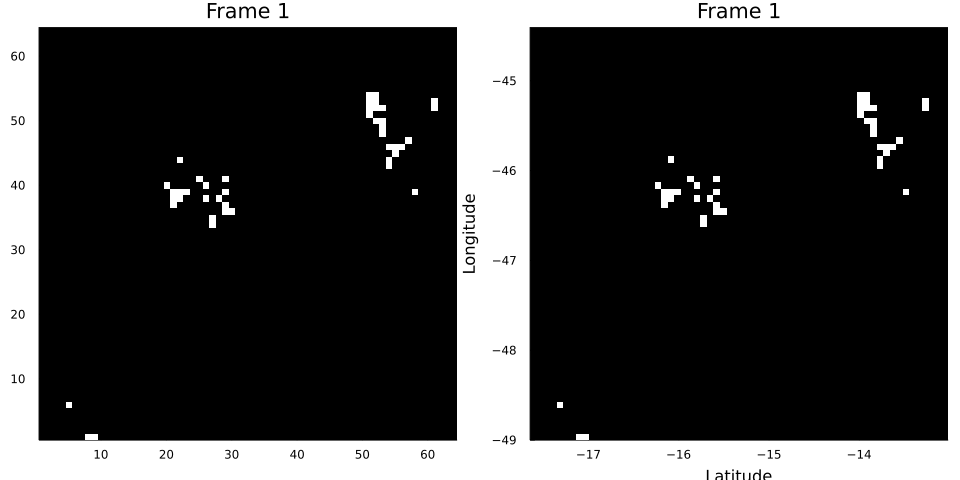

In [43]:
predicted = rolling_predictions(model, dataset, 16, 16);
animation_comparation(predicted, ds[i], 4)

In [17]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 16, 64, 64, 1)]   0         
                                                                 
 conv_lst_m2d_15 (ConvLSTM2D  (None, 16, 64, 64, 64)   416256    
 )                                                               
                                                                 
 dropout_7 (Dropout)         (None, 16, 64, 64, 64)    0         
                                                                 
 conv_lst_m2d_16 (ConvLSTM2D  (None, 16, 64, 64, 64)   295168    
 )                                                               
                                                                 
 dropout_8 (Dropout)         (None, 16, 64, 64, 64)    0         
                                                                 
 conv_lst_m2d_17 (ConvLSTM2D  (None, 16, 64, 64, 64)   3302

 10.797146 seconds (34.23 M allocations: 1.735 GiB, 3.28% gc time, 89.97% compilation time)


┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\coolh\.julia\packages\PyCall\L0fLP\src\numpy.jl:67
┌ Info: Saved animation to 
│   fn = E:\nowcasting-huascaran\notebooks\tmp.gif
└ @ Plots C:\Users\coolh\.julia\packages\Plots\LI4FE\src\animation.jl:114


Plots.AnimatedGif("E:\\nowcasting-huascaran\\notebooks\\tmp.gif")
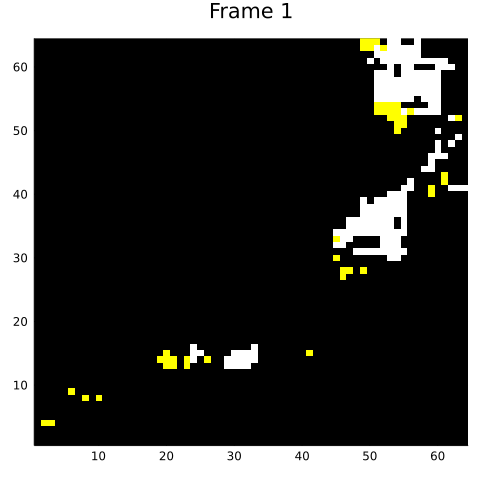

In [18]:
T_START = 60
TIME = 16
X_MAX = 1
X, y = ds[i].data[:, :, T_START:T_START+TIME-1], ds[i].data[:, :, T_START+TIME:T_START+TIME*2]
X = permutedims(reshape(X, (1, 64, 64, TIME, 1)), (5,4,3,2,1))

#y = permutedims(model.predict(X / X_MAX), (5,4,3,2,1)) * X_MAX
predicted_y = permutedims(model.predict(X / X_MAX), (5,4,3,2,1)) * X_MAX
predicted_y = predicted_y[1, :, :, :, 1]
#animation_comparation((predicted_y), y, 2)
zerotonan(x) = x == 0 ? NaN : x
animation_comparation_colors(predicted_y .> 0.1, zerotonan.(y), 2)

In [ ]:
maximum(predicted_y)

In [ ]:
using Images

In [ ]:
# Balancear el conjunto de datos respecto al maximo de densidad de rayos
# Grafica de residuales o scatterplot (diferencia del target vs. predicho en eje y, eje x valor target)

In [ ]:
# [0, 1>
# [1, x>...

In [ ]:
start = 50
X_ds, y = ds[i].data[:, :, start:start+n-1], ds[i].data[:, :, start+n:start+2n-1]
X = permutedims(reshape(X_ds, (1, 64, 64, 8, 1)), (5,4,3,2,1))
X_max = maximum(X)
ŷ = permutedims(model.predict(X / X_max), (5,4,3,2,1))
losses = [Flux.Losses.binarycrossentropy(ŷ[1,:,:,i,1], X_ds[:, :, i] / X_max) for i in 1:n]
plot(losses)

In [ ]:
?Flux.Losses.binarycrossentropy